<a href="https://colab.research.google.com/github/ai-project-2023/Speech_grading_multimodal/blob/nlp%2Fspeechtotext/CER_wo_val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
from CER import train_model

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/AI_Project_14/CERModel/dataset_grammer/final_df_20211027.csv')
df = df.rename(columns={'correct': 'target_data', 'incorrect': 'input_data'})
df = df.head(100)
df = df.applymap(lambda x: x.split())
df = df.rename_axis('id').reset_index()
df = df.to_dict(orient='records')

Epoch [1/100], Step [1/4], Loss: 4.1972
Epoch [1/100], Step [2/4], Loss: 4.1899
Epoch [1/100], Step [3/4], Loss: 4.1877
Epoch [1/100], Step [4/4], Loss: 4.1765
Epoch [2/100], Step [1/4], Loss: 4.1737
Epoch [2/100], Step [2/4], Loss: 4.1666
Epoch [2/100], Step [3/4], Loss: 4.1630
Epoch [2/100], Step [4/4], Loss: 4.1452
Epoch [3/100], Step [1/4], Loss: 4.1476
Epoch [3/100], Step [2/4], Loss: 4.1394
Epoch [3/100], Step [3/4], Loss: 4.1337
Epoch [3/100], Step [4/4], Loss: 4.1225
Epoch [4/100], Step [1/4], Loss: 4.1167
Epoch [4/100], Step [2/4], Loss: 4.1055
Epoch [4/100], Step [3/4], Loss: 4.0975
Epoch [4/100], Step [4/4], Loss: 4.0832
Epoch [5/100], Step [1/4], Loss: 4.0756
Epoch [5/100], Step [2/4], Loss: 4.0581
Epoch [5/100], Step [3/4], Loss: 4.0425
Epoch [5/100], Step [4/4], Loss: 4.0177
Epoch [6/100], Step [1/4], Loss: 4.0026
Epoch [6/100], Step [2/4], Loss: 3.9815
Epoch [6/100], Step [3/4], Loss: 3.9430
Epoch [6/100], Step [4/4], Loss: 3.9182
Epoch [7/100], Step [1/4], Loss: 3.8633


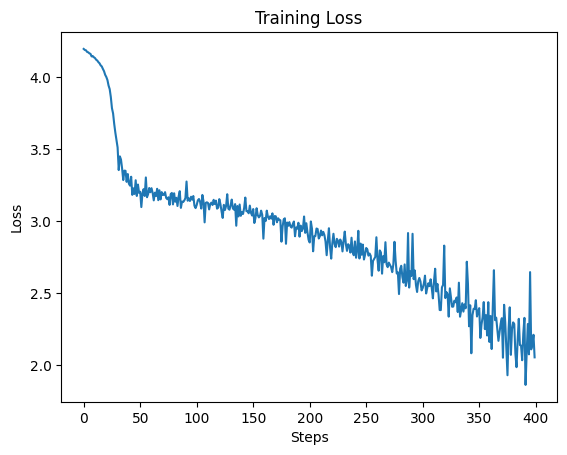

In [ ]:
cer_model = train_model(df)

In [ ]:
with open('trained_model_e100_b32.pkl', 'wb') as f:
    pickle.dump(cer_model, f)

In [ ]:
with open('trained_model_e100_b32.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
import editdistance
import torch
def calculate_cer(cer_model, input_data, target_data, char_to_idx, idx_to_char, sequence_length, device):
    cer_model.eval()
    with torch.no_grad():
        total_cer = 0
        max_length = max(len(input_data), len(target_data))  # 최소 길이 계산
        for i in range(max_length):  # 최소 길이까지만 반복
            input = input_data[i].ljust(sequence_length, PAD_CHAR)
            target = target_data[i].ljust(sequence_length, PAD_CHAR)
            
            input_onehot = torch.zeros(sequence_length, len(char_to_idx)).to(device)
            for i, char in enumerate(input):
                input_onehot[i][char_to_idx[char]] = 1
            input_onehot = input_onehot.unsqueeze(0)
            
            output = cer_model(input_onehot)
            output = output.view(-1, len(char_to_idx))
            output = torch.argmax(output, dim=1)
            
            target_idx = torch.zeros(sequence_length).long().to(device)
            for i, char in enumerate(target):
                target_idx[i] = char_to_idx[char]
            
            # Convert output indices back into characters
            output_chars = ''.join([idx_to_char[idx] for idx in output.cpu().numpy()])
            target_chars = ''.join([idx_to_char[idx] for idx in target_idx.cpu().numpy()])
            
            # Calculate edit distance only up to the length of the shorter string
            total_cer += editdistance.eval(output_chars, target_chars) / max(len(output_chars), len(target_chars))
        
        return total_cer / min_length  # 평균 CER 계산


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
cer_model = model.to(device)

In [ ]:
test_data = [
  {'input_data': ['They', 'are', 'planned', 'to', 'build', 'a', 'model','.'], 'target_data': ['They', 'are', 'planned', 'to', 'build', 'a', 'model','.'], 'id': '1'},
]

In [ ]:
test_input_data = [word for row in test_data for word in row['input_data']]
test_target_data = [word for row in test_data for word in row['target_data']]

In [ ]:
PAD_CHAR = '-'
char_set = set(
        ''.join([''.join(row['input_data']) for row in df] + [''.join(row['target_data']) for row in df]))
char_set.add(PAD_CHAR)
idx_to_char = {i: char for i, char in enumerate(char_set)}
char_to_idx = {char: i for i, char in idx_to_char.items()}

# Define a suitable sequence length
max_input_length = max([len(''.join(row['input_data'])) for row in df])
max_target_length = max([len(''.join(row['target_data'])) for row in df])

sequence_length = max(max_input_length, max_target_length)

In [ ]:
cer = calculate_cer(cer_model, test_input_data, test_target_data, char_to_idx, idx_to_char, sequence_length, device)
print('Character Error Rate:', cer)

Character Error Rate: 0.9798657718120805
